In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import json
from collections import Counter
import matplotlib.dates as mdates
import geopandas as gpd
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [43]:
plt.style.use('ggplot')
sns.set(style="whitegrid")

In [44]:
def load_data(requests_path, providers_path=None, merged_path=None):
    """
    Load and prepare the dataset for error analysis

    Args:
        requests_path: Path to the requests data CSV
        providers_path: Path to the providers data CSV
        merged_path: Path to the merged data CSV

    Returns:
        df_requests: DataFrame containing request data
        df_merged: DataFrame containing merged data (if provided)
    """
    print("Loading datasets...")

    # Load requests data
    df_requests = pd.read_csv(requests_path)

    # Convert timestamp to datetime
    if 'timestamp' in df_requests.columns:
        df_requests['timestamp'] = pd.to_datetime(df_requests['timestamp'])

    # Load merged data if path is provided
    if merged_path and os.path.exists(merged_path):
        df_merged = pd.read_csv(merged_path)
        if 'timestamp' in df_merged.columns:
            df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])
        return df_requests, df_merged

    # Otherwise, if providers path is provided, create merged data
    elif providers_path and os.path.exists(providers_path):
        df_providers = pd.read_csv(providers_path)
        # Merge based on the understanding from the GitHub code
        # Assuming merging on CID
        if 'cid' in df_requests.columns and 'cid' in df_providers.columns:
            df_merged = pd.merge(df_requests, df_providers, on='cid', how='left')
            return df_requests, df_merged

    # If no merged data can be created
    return df_requests, None

In [45]:
def categorize_errors(df):
    """
    Categorize errors based on HTTP status codes and system-specific error codes

    Args:
        df: DataFrame containing status codes

    Returns:
        DataFrame with additional error category columns
    """
    print("Categorizing errors...")

    # Create a copy to avoid warnings
    df = df.copy()

    # Define error categories based on HTTP status codes
    df['error_category'] = 'Success'  # Default

    # Client errors (4xx)
    client_errors = (df['status'] >= 400) & (df['status'] < 500)
    df.loc[client_errors, 'error_category'] = 'Client Error'

    # Server errors (5xx)
    server_errors = df['status'] >= 500
    df.loc[server_errors, 'error_category'] = 'Server Error'

    # More specific error categorization
    # 404 - Not Found
    not_found = df['status'] == 404
    df.loc[not_found, 'error_subcategory'] = 'Not Found'

    # 408 - Request Timeout
    timeout = df['status'] == 408
    df.loc[timeout, 'error_subcategory'] = 'Request Timeout'

    # 429 - Too Many Requests
    too_many = df['status'] == 429
    df.loc[too_many, 'error_subcategory'] = 'Rate Limited'

    # 500 - Internal Server Error
    internal_error = df['status'] == 500
    df.loc[internal_error, 'error_subcategory'] = 'Internal Server Error'

    # 502 - Bad Gateway
    bad_gateway = df['status'] == 502
    df.loc[bad_gateway, 'error_subcategory'] = 'Bad Gateway'

    # 503 - Service Unavailable
    unavailable = df['status'] == 503
    df.loc[unavailable, 'error_subcategory'] = 'Service Unavailable'

    # 504 - Gateway Timeout
    gateway_timeout = df['status'] == 504
    df.loc[gateway_timeout, 'error_subcategory'] = 'Gateway Timeout'

    # Fill NaN values in error_subcategory
    successful = df['status'] < 400
    df.loc[successful, 'error_subcategory'] = 'Success'

    # Fill remaining NaNs with 'Other'
    df['error_subcategory'] = df['error_subcategory'].fillna('Other')

    # Flag all errors
    df['is_error'] = ~(df['status'] < 400)

    return df

In [46]:
def temporal_analysis(df):
    """
    Analyze error patterns over time

    Args:
        df: DataFrame with categorized errors

    Returns:
        Temporal analysis results and visualizations
    """
    print("Performing temporal analysis...")

    # Ensure timestamp column exists
    if 'timestamp' not in df.columns:
        print("Error: timestamp column not found in the dataset")
        return None

    # Create time-based features
    df['hour'] = df['timestamp'].dt.hour
    df['day'] = df['timestamp'].dt.day
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['week'] = df['timestamp'].dt.isocalendar().week

    # Hourly error rate
    hourly_errors = df.groupby(['hour', 'error_category']).size().unstack().fillna(0)
    hourly_total = df.groupby('hour').size()
    hourly_error_rate = hourly_errors.div(hourly_total, axis=0) * 100

    # Daily error rate
    daily_errors = df.groupby(['day', 'error_category']).size().unstack().fillna(0)
    daily_total = df.groupby('day').size()
    daily_error_rate = daily_errors.div(daily_total, axis=0) * 100

    # Day of week error rate
    dow_errors = df.groupby(['day_of_week', 'error_category']).size().unstack().fillna(0)
    dow_total = df.groupby('day_of_week').size()
    dow_error_rate = dow_errors.div(dow_total, axis=0) * 100

    # Create visualizations
    fig, axes = plt.subplots(3, 1, figsize=(15, 18))

    # Plot hourly error rate
    hourly_error_rate.plot(kind='bar', stacked=True, ax=axes[0])
    axes[0].set_title('Hourly Error Rate Distribution')
    axes[0].set_xlabel('Hour of Day')
    axes[0].set_ylabel('Error Rate (%)')
    axes[0].legend(title='Error Category')

    # Plot daily error rate
    daily_error_rate.plot(kind='bar', stacked=True, ax=axes[1])
    axes[1].set_title('Daily Error Rate Distribution')
    axes[1].set_xlabel('Day of Month')
    axes[1].set_ylabel('Error Rate (%)')
    axes[1].legend(title='Error Category')

    # Plot day of week error rate
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow_error_rate.index = [day_names[i] for i in dow_error_rate.index]
    dow_error_rate.plot(kind='bar', stacked=True, ax=axes[2])
    axes[2].set_title('Day of Week Error Rate Distribution')
    axes[2].set_xlabel('Day of Week')
    axes[2].set_ylabel('Error Rate (%)')
    axes[2].legend(title='Error Category')

    plt.tight_layout()
    # plt.savefig('temporal_error_analysis.png')
    plt.show()

    # Create time series plot for error frequency
    plt.figure(figsize=(15, 8))

    # Resample by hour and count errors
    errors_by_hour = df[df['is_error']].set_index('timestamp').resample('H').size()
    total_by_hour = df.set_index('timestamp').resample('H').size()
    error_rate_by_hour = (errors_by_hour / total_by_hour) * 100

    plt.plot(error_rate_by_hour.index, error_rate_by_hour.values, marker='o', linestyle='-')
    plt.title('Error Rate Over Time')
    plt.xlabel('Time')
    plt.ylabel('Error Rate (%)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    # plt.savefig('error_rate_time_series.png')

    return {
        'hourly_error_rate': hourly_error_rate,
        'daily_error_rate': daily_error_rate,
        'dow_error_rate': dow_error_rate,
        'error_rate_time_series': error_rate_by_hour
    }

In [47]:
def geographical_analysis(df):
    """
    Analyze error patterns by geographical location if available

    Args:
        df: DataFrame with error categories and geographical information

    Returns:
        Geographical analysis results and visualizations
    """
    print("Performing geographical analysis...")

    # Check if geographic information is available
    geo_columns = [col for col in df.columns if col in ['country', 'continent', 'region', 'city', 'latitude', 'longitude']]

    if not geo_columns:
        print("Warning: No geographical information found in the dataset")
        return None

    results = {}

    # Analyze error rates by available geographical dimensions
    for geo_col in geo_columns:
        # Skip if column has mostly NaN values
        if df[geo_col].isna().mean() > 0.5:
            continue

        # Group by geographical dimension and error category
        geo_errors = df.groupby([geo_col, 'error_category']).size().unstack().fillna(0)
        geo_total = df.groupby(geo_col).size()
        geo_error_rate = geo_errors.div(geo_total, axis=0) * 100

        # Store results
        results[f'{geo_col}_error_rate'] = geo_error_rate

        # Create visualization
        plt.figure(figsize=(15, 8))
        geo_error_rate.plot(kind='bar', stacked=True)
        plt.title(f'Error Rate by {geo_col.capitalize()}')
        plt.xlabel(geo_col.capitalize())
        plt.ylabel('Error Rate (%)')
        plt.xticks(rotation=90)
        plt.legend(title='Error Category')
        plt.tight_layout()
        plt.show()
        # plt.savefig(f'error_rate_by_{geo_col}.png')

    # If latitude and longitude are available, create a heatmap
    if 'latitude' in df.columns and 'longitude' in df.columns:
        plt.figure(figsize=(15, 10))

        # Filter for errors and valid coordinates
        error_map = df[df['is_error'] & df['latitude'].notna() & df['longitude'].notna()]

        # Create scatter plot
        plt.scatter(
            error_map['longitude'],
            error_map['latitude'],
            c=error_map['status'],
            cmap='viridis',
            alpha=0.7,
            s=50
        )

        plt.colorbar(label='Status Code')
        plt.title('Geographical Distribution of Errors')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        # plt.savefig('geographical_error_distribution.png')

        # Add to results
        results['geo_error_map'] = error_map

    return results

In [ ]:
from collections import namedtuple

BurstInfo = namedtuple('BurstInfo', [
    'start_time',
    'end_time',
    'duration',
    'peak_error_count'
])

def analyze_error_bursts(
    df: pd.DataFrame,
    timestamp_col: str = 'timestamp',
    error_flag_col: str = 'is_error',
    window_size: pd.Timedelta = pd.Timedelta('5min'),
    burst_threshold: int = 10
):
    """
    Analyze error burst patterns in an IPFS workload:
    any time window of length `window_size` in which the number of errors
    ≥ `burst_threshold` is considered a burst.

    Returns:
        {
            'bursts': List of BurstInfo,
            'summary': {'n_bursts', 'avg_duration_s', 'max_duration_s'},
            'rolling': pd.Series of rolling counts (unique index)
        }
    """
    # 1. Prepare and index the data chronologically
    df_sorted = (
        df
        .assign(**{timestamp_col: pd.to_datetime(df[timestamp_col])})
        .sort_values(timestamp_col)
        .set_index(timestamp_col)
    )

    # 2. Compute the time-based rolling error count
    rolling = (
        df_sorted[error_flag_col]
        .rolling(window=window_size)
        .sum()
        .rename('rolling_error_count')
    )

    # 3. Collapse duplicate timestamps by taking the max per timestamp label
    #    This ensures .at[time] returns a scalar, not a Series :contentReference[oaicite:2]{index=2}.
    rolling_unique = rolling.groupby(level=0).max()

    # 4. Flag timestamps exceeding the burst threshold
    is_burst = rolling_unique >= burst_threshold

    # 5. Identify contiguous burst segments
    bursts = []
    burst_active = False

    for time, flag in is_burst.items():            # use .items(), not deprecated .iteritems() :contentReference[oaicite:3]{index=3}
        if flag and not burst_active:
            start_time = time
            peak = rolling_unique.at[time]         # now returns a scalar
            burst_active = True

        elif flag and burst_active:
            current = rolling_unique.at[time]      # safe scalar access
            peak = max(peak, current)

        elif not flag and burst_active:
            end_time = time
            duration = end_time - start_time
            bursts.append(BurstInfo(start_time, end_time, duration, peak))
            burst_active = False

    # Handle ongoing burst at the end of series
    if burst_active:
        end_time = is_burst.index[-1]
        duration = end_time - start_time
        bursts.append(BurstInfo(start_time, end_time, duration, peak))

    # 6. Summarize burst statistics
    durations = [b.duration.total_seconds() for b in bursts]
    summary = {
        'n_bursts': len(bursts),
        'avg_duration_s': float(np.mean(durations)) if durations else 0.0,
        'max_duration_s': float(np.max(durations)) if durations else 0.0
    }

    # 7. Visualization
    fig, ax = plt.subplots(figsize=(12, 4))
    rolling_unique.plot(ax=ax, label='Rolling Error Count')
    ax.axhline(burst_threshold, color='red', linestyle='--', label='Burst Threshold')
    ax.set_title('Rolling Error Count vs. Burst Threshold')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Errors per Window')
    ax.legend()
    plt.tight_layout()
    plt.show()

    return {
        'bursts': bursts,
        'summary': summary,
        'rolling': rolling_unique
    }


In [53]:
def _make_numeric(df, cols):
    """
    Returns a copy of df[cols] where any datetime64 column
    has been viewed as int64 (ns since epoch), so that
    astype(float) will succeed.
    """
    X = df[cols].copy()
    for c in cols:
        if pd.api.types.is_datetime64_any_dtype(X[c]):
            # convert datetime → int nanoseconds
            X[c] = X[c].view('int64')
    return X


In [89]:
import re

def clean_numeric_series(s):
    """
    Strip away any non‑numeric noise (brackets, quotes, letters, etc.)
    and attempt to parse out a float.
    """
    # 1) Convert everything to string
    s = s.astype(str)
    # 2) Remove any enclosing brackets or quotes
    s = s.str.strip("[]'\" ")
    # 3) Use a regex to extract the first valid numeric pattern (including decimal point)
    #    This will grab things like -12.34 or 56
    num = s.str.extract(r'([-+]?\d*\.?\d+)')[0]
    return pd.to_numeric(num, errors='coerce')

def advanced_error_analysis(df, merged_df=None):
    """
    Perform additional advanced error analysis tasks

    Args:
        df: DataFrame with request data
        merged_df: Optional merged DataFrame with provider data

    Returns:
        Advanced analysis results
    """
    print("Performing advanced error analysis...")

    results = {}

    # 1. Error prediction model - identify factors that predict errors
    if 'is_error' in df.columns:
        # 1a) Define candidate features
        base_features = [
            'request_time', 
            'upstream_response_time', 
            'upstream_header_time',
            'body_bytes',
            'request_length',
        ]
        features = [f for f in base_features if f in df.columns]

        # 1b) Clean any string columns in-place
        for col in features:
            if df[col].dtype == object:
                df[col] = clean_numeric_series(df[col])

        # 1c) Encode categorical / datetime features
        if 'day' in features:
            dow_map = {'Monday':0,'Tuesday':1,'Wednesday':2,'Thursday':3,
                       'Friday':4,'Saturday':5,'Sunday':6}
            df['day_code'] = df['day'].map(dow_map)
            features[features.index('day')] = 'day_code'

        if 'day_of_week' in features:
            if np.issubdtype(df['day_of_week'].dtype, np.datetime64):
                df['dow_num'] = df['day_of_week'].dt.weekday
            else:
                df['dow_num'] = df['day_of_week'].astype(int)
            features[features.index('day_of_week')] = 'dow_num'

        if 'status' in features:
            df['status_code'] = df['status'].astype(int) // 100
            features[features.index('status')] = 'status_code'

        # 1d) Build X, y
        if features:
            # Assume _make_numeric simply casts remaining dtypes to numeric
            X = _make_numeric(df, features).fillna(-1).astype(float)
        else:
            X = pd.DataFrame(index=df.index)  # empty but defined

        y = df['is_error']

        # 1e) Only model if we have at least one feature column
        if X.shape[1] > 0:
            from sklearn.ensemble import RandomForestClassifier
            from sklearn.model_selection import train_test_split
            from sklearn.metrics import confusion_matrix, classification_report

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=42
            )
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)

            # Feature importance
            feat_imp = pd.DataFrame({
                'Feature': X.columns,
                'Importance': model.feature_importances_
            }).sort_values('Importance', ascending=False)
            results['feature_importance'] = feat_imp

            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feat_imp)
            plt.title('Features That Predict Errors')
            plt.tight_layout()
            plt.show()

            # Accuracy & confusion
            acc = model.score(X_test, y_test)
            y_pred = model.predict(X_test)
            cm = confusion_matrix(y_test, y_pred)
            cr = classification_report(y_test, y_pred, output_dict=True)

            results.update({
                'model_accuracy': acc,
                'confusion_matrix': cm,
                'classification_report': cr
            })
            print(f"Error prediction model accuracy: {acc:.4f}")

            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=['OK','Error'], yticklabels=['OK','Error'])
            plt.title('Confusion Matrix for Error Prediction')
            plt.tight_layout()
            plt.show()
        else:
            print("No numeric features available for error prediction modeling.")
    # 2. Provider-specific error analysis
    if merged_df is not None and 'provider' in merged_df.columns:
        # Calculate error rates by provider
        provider_stats = merged_df.groupby('provider').agg(
            total_requests=('req_id', 'count'),
            error_count=('is_error', 'sum')
        )
        provider_stats['error_rate'] = provider_stats['error_count'] / provider_stats['total_requests'] * 100

        # Sort by error rate
        provider_stats = provider_stats.sort_values('error_rate', ascending=False)

        # Visualize provider error rates
        plt.figure(figsize=(12, 8))
        sns.barplot(x=provider_stats.index, y=provider_stats['error_rate'])
        plt.title('Error Rates by Provider')
        plt.xlabel('Provider')
        plt.ylabel('Error Rate (%)')
        plt.xticks(rotation=90)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        # plt.savefig('provider_error_rates.png')

        # Add to results
        results['provider_error_rates'] = provider_stats

        # Analyze specific error types by provider
        if len(merged_df) > 0:
            # Get top 5 providers by request volume
            top_providers = merged_df['provider'].value_counts().nlargest(5).index

            # Filter for these providers
            top_provider_data = merged_df[merged_df['provider'].isin(top_providers)]

            # Create cross-tabulation of providers and error subcategories
            provider_error_types = pd.crosstab(
                top_provider_data['provider'],
                top_provider_data['error_subcategory'],
                normalize='index'
            ) * 100  # Convert to percentages

            # Visualize as heatmap
            plt.figure(figsize=(14, 8))
            sns.heatmap(provider_error_types, annot=True, fmt='.1f', cmap='YlOrRd')
            plt.title('Error Types by Provider (%)')
            plt.tight_layout()
            plt.show()
            # plt.savefig('provider_error_types.png')

            # Add to results
            results['provider_error_types'] = provider_error_types

    # 3. Content-specific error analysis
    if 'cid' in df.columns:
        # Calculate error rates by content ID
        content_stats = df.groupby('cid').agg(
            request_count=('req_id', 'count'),
            error_count=('is_error', 'sum')
        )
        content_stats['error_rate'] = content_stats['error_count'] / content_stats['request_count'] * 100

        # Find content with high error rates and significant request volume
        high_error_content = content_stats[
            (content_stats['error_rate'] > 50) &
            (content_stats['request_count'] >= 5)
        ].sort_values('request_count', ascending=False)

        # Visualize top problematic content
        if len(high_error_content) > 0:
            top_n = min(10, len(high_error_content))
            plt.figure(figsize=(12, 8))

            top_error_content = high_error_content.nlargest(top_n, 'request_count')

            sns.barplot(
                x=top_error_content.index,
                y=top_error_content['error_rate']
            )
            plt.title(f'Top {top_n} Contents with High Error Rates')
            plt.xlabel('Content ID')
            plt.ylabel('Error Rate (%)')
            plt.xticks(rotation=90)
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            # plt.savefig('high_error_content.png')

            # Add to results
            results['high_error_content'] = high_error_content

    return results

In [55]:
print("Starting IPFS Gateway Error Analysis...")
print(os.getcwd())

requests_path = '/Users/anuj/IPFS-location-requested-content/scripts/data/sample/sample_data_raw.csv'
providers_path = '/Users/anuj/IPFS-location-requested-content/scripts/data/sample/providers.csv'
merged_path = '/Users/anuj/IPFS-location-requested-content/scripts/data/sample/merged.csv'

Starting IPFS Gateway Error Analysis...
/Users/anuj/IPFS-location-requested-content/scripts


In [56]:
# Load data
df_requests, df_merged = load_data(requests_path, providers_path, merged_path)

df_requests.dropna(inplace=True)
df_merged.dropna(inplace=True)

Loading datasets...


In [57]:
# Check if data loaded successfully
if df_requests is None or len(df_requests) == 0:
    print("Error: Failed to load request data or empty dataset")


print(f"Loaded {len(df_requests)} request records")
if df_merged is not None:
    print(f"Loaded {len(df_merged)} merged records")

Loaded 195846 request records
Loaded 28985 merged records


In [75]:
# Ensure required columns exist
df_requests['req_id'] = df_requests.index
required_columns = ['req_id', 'status']
if not all(col in df_requests.columns for col in required_columns):
    print(f"Error: Missing required columns. Available columns: {df_requests.columns.tolist()}")

import re
df_requests['timestamp'] = df_requests['time'].apply(lambda x: datetime.strptime(
    re.sub(r'([+-]\d{2}):(\d{2})', r'\1\2', x.strip('[]')),
    "%Y-%m-%dT%H:%M:%S%z"
))

In [59]:
# Step 1: Categorize errors
df_with_categories = categorize_errors(df_requests)

# Create an overall summary of findings
results = {}

Categorizing errors...


Performing geographical analysis...


<Figure size 1500x800 with 0 Axes>

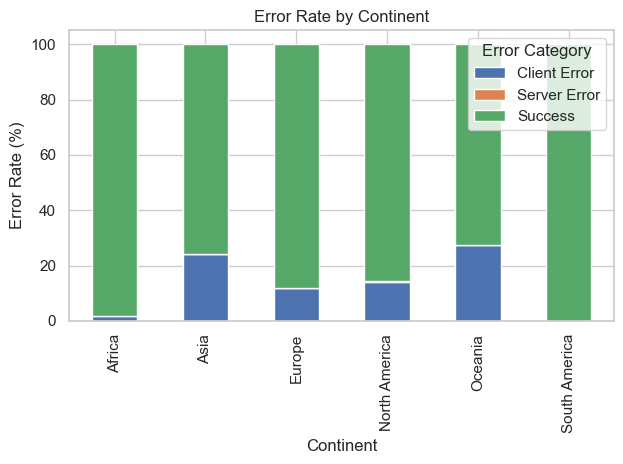

<Figure size 1500x800 with 0 Axes>

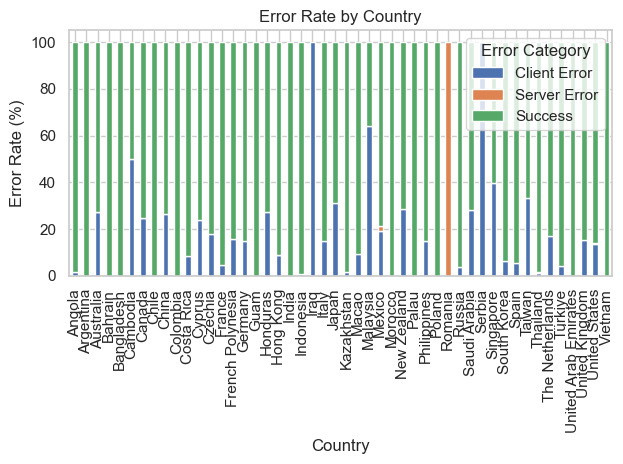

In [61]:
# Step 3: Geographical Analysis (if geographical data available)
geo_results = geographical_analysis(df_with_categories)
if geo_results:
    results['geographical_analysis'] = geo_results

In [152]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict

def analyze_error_bursts(
    df: pd.DataFrame,
    timestamp_col: str = 'timestamp',
    error_flag_col: str = 'is_error',
    window_size: pd.Timedelta = pd.Timedelta('2min'),
    burst_threshold: int = 1000
) -> Dict:
    """
    Analyze error bursts where the count of `is_error` in any
    time window ≥ burst_threshold is considered a burst.
    Returns:
      - bursts: List of dicts(start, end, count, duration_s, peak)
      - summary: {'n_bursts', 'avg_duration_s', 'max_duration_s'}
      - rolling: pd.Series of rolling sums
    """
    # 1. Chronologically index by timestamp
    df2 = (
        df
        .assign(**{timestamp_col: pd.to_datetime(df[timestamp_col])})
        .sort_values(timestamp_col)
        .set_index(timestamp_col)
    )

    # 2. Compute time-based rolling sum of errors :contentReference[oaicite:7]{index=7}
    rolling = df2[error_flag_col].rolling(window=window_size).sum()

    # 3. Collapse duplicates by taking max per timestamp :contentReference[oaicite:8]{index=8}
    rolling_uq = rolling.groupby(level=0).max().rename('rolling_count')

    # 4. Flag windows above the burst threshold
    is_burst = rolling_uq >= burst_threshold

    # 5. Extract contiguous burst segments
    bursts: List[Dict] = []
    active = False
    for ts, flag in is_burst.items():  # use .items() for scalar flag :contentReference[oaicite:9]{index=9}
        if flag and not active:
            start = ts
            peak = rolling_uq.at[ts]
            active = True
        elif flag and active:
            peak = max(peak, rolling_uq.at[ts])
        elif active:
            end = ts
            seg = rolling_uq[start:end] >= burst_threshold
            bursts.append({
                'start': start,
                'end': end,
                'count': int(seg.sum()),
                'duration_s': (end - start).total_seconds(),
                'peak': float(peak)
            })
            active = False

    # Finalize if still in burst
    if active:
        end = is_burst.index[-1]
        seg = rolling_uq[start:end] >= burst_threshold
        bursts.append({
            'start': start,
            'end': end,
            'count': int(seg.sum()),
            'duration_s': (end - start).total_seconds(),
            'peak': float(peak)
        })

    # 6. Summary statistics
    durations = [b['duration_s'] for b in bursts]
    summary = {
        'n_bursts': len(bursts),
        'avg_duration_s': float(np.mean(durations)) if durations else 0.0,
        'max_duration_s': float(np.max(durations)) if durations else 0.0
    }

    # 7. Visualization with shaded bursts :contentReference[oaicite:10]{index=10}
    fig, ax = plt.subplots(figsize=(12, 4))
    rolling_uq.plot(ax=ax, label='Rolling Error Count')
    ax.axhline(burst_threshold, color='red', linestyle='--',
               label=f'Threshold = {burst_threshold}')
    for b in bursts:
        ax.axvspan(b['start'], b['end'], color='red', alpha=0.3)
    ax.set_title('Error Burst Analysis')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Errors per Window')
    ax.legend()
    plt.tight_layout()
    plt.show()

    return {
        'bursts': bursts,
        'summary': summary,
        'rolling': rolling_uq
    }


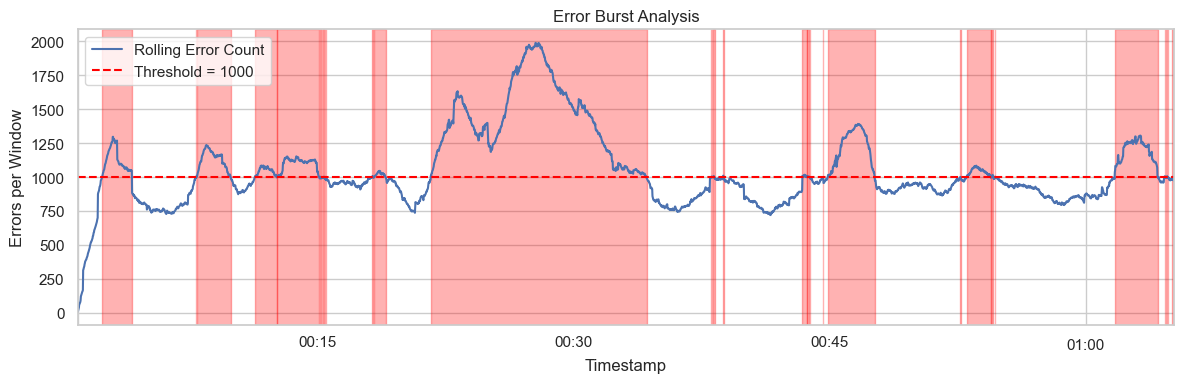

{'bursts': [{'start': Timestamp('2022-03-21 00:02:24+0000', tz='UTC'),
   'end': Timestamp('2022-03-21 00:04:09+0000', tz='UTC'),
   'count': 105,
   'duration_s': 105.0,
   'peak': 1297.0},
  {'start': Timestamp('2022-03-21 00:07:54+0000', tz='UTC'),
   'end': Timestamp('2022-03-21 00:07:55+0000', tz='UTC'),
   'count': 1,
   'duration_s': 1.0,
   'peak': 1003.0},
  {'start': Timestamp('2022-03-21 00:07:56+0000', tz='UTC'),
   'end': Timestamp('2022-03-21 00:09:56+0000', tz='UTC'),
   'count': 120,
   'duration_s': 120.0,
   'peak': 1236.0},
  {'start': Timestamp('2022-03-21 00:11:21+0000', tz='UTC'),
   'end': Timestamp('2022-03-21 00:12:37+0000', tz='UTC'),
   'count': 76,
   'duration_s': 76.0,
   'peak': 1085.0},
  {'start': Timestamp('2022-03-21 00:12:39+0000', tz='UTC'),
   'end': Timestamp('2022-03-21 00:15:07+0000', tz='UTC'),
   'count': 148,
   'duration_s': 148.0,
   'peak': 1152.0},
  {'start': Timestamp('2022-03-21 00:15:11+0000', tz='UTC'),
   'end': Timestamp('2022-03-2

In [153]:
analyze_error_bursts(df_requests)

Performing advanced error analysis...


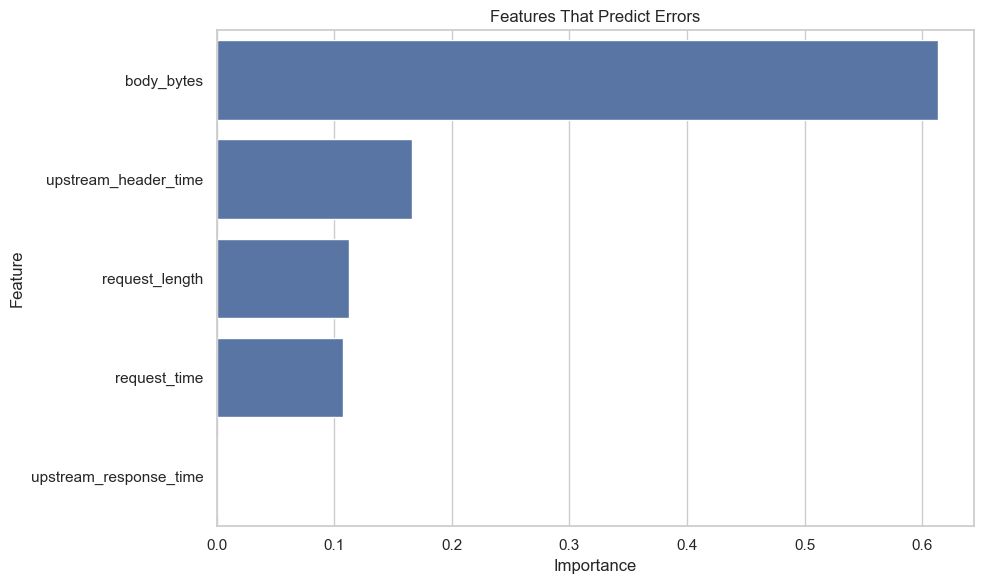

Error prediction model accuracy: 0.9938


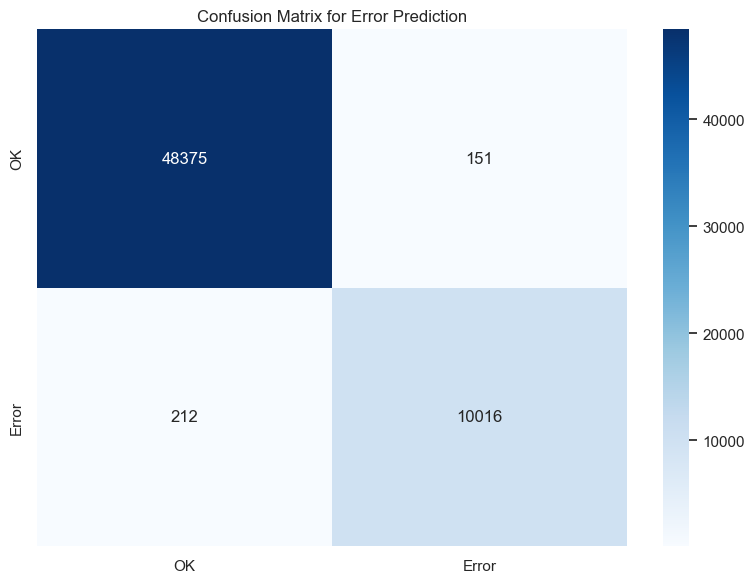

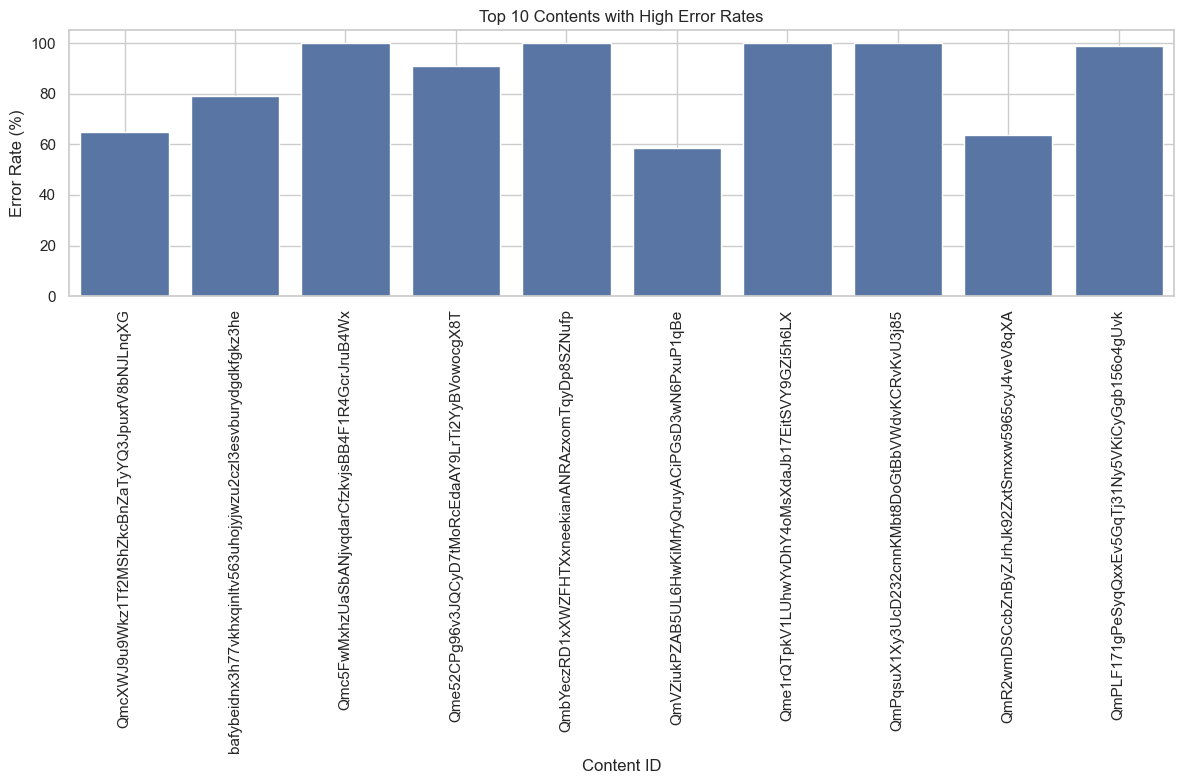

In [90]:
# Step 9: Perform Advanced Analysis
advanced_results = advanced_error_analysis(df_with_categories, df_merged)
if advanced_results:
    results['advanced_analysis'] = advanced_results

In [68]:
def generate_summary_report(results, recommendations):
    """
    Generate a comprehensive summary report of all analyses

    Args:
        results: Dictionary containing all analysis results
        recommendations: List of system design recommendations
    """
    with open('error_analysis_summary.md', 'w') as f:
        f.write("# IPFS Gateway Error Analysis Summary\n\n")

        # Overall error statistics
        error_pattern = results.get('error_pattern', {})
        if error_pattern:
            f.write("## Overall Error Statistics\n\n")
            f.write(f"- Overall Error Rate: {error_pattern.get('overall_error_rate', 0):.2f}%\n")

            error_categories = error_pattern.get('error_category_counts')
            if error_categories is not None:
                f.write("- Error Category Distribution:\n")
                for category, count in error_categories.items():
                    f.write(f"  - {category}: {count} ({count/error_categories.sum()*100:.2f}%)\n")

            error_subcategories = error_pattern.get('error_subcategory_counts')
            if error_subcategories is not None and len(error_subcategories) > 0:
                f.write("- Error Subcategory Distribution:\n")
                for subcategory, count in error_subcategories.items():
                    f.write(f"  - {subcategory}: {count} ({count/error_subcategories.sum()*100:.2f}%)\n")

            f.write("\n")

        # Geographical patterns
        geographical_analysis = results.get('geographical_analysis', {})
        if geographical_analysis:
            f.write("## Geographical Error Patterns\n\n")
            f.write("- Error distribution varies by geographic location\n")
            f.write("- Refer to geographical analysis charts for specific patterns\n\n")

        # Error bursts
        burst_analysis = results.get('burst_analysis', {})
        if burst_analysis:
            f.write("## Error Burst Analysis\n\n")
            f.write(f"- Average Error Burst Length: {burst_analysis.get('avg_burst_length', 0):.2f}\n")
            f.write(f"- Maximum Error Burst Length: {burst_analysis.get('max_burst_length', 0)}\n\n")

        # Advanced analysis
        advanced_analysis = results.get('advanced_analysis', {})
        if advanced_analysis:
            f.write("## Advanced Analysis\n\n")

            # Error prediction model
            if 'model_accuracy' in advanced_analysis:
                f.write(f"- Error Prediction Model Accuracy: {advanced_analysis['model_accuracy']:.2f}\n")

            # Provider analysis
            if 'provider_error_rates' in advanced_analysis:
                provider_stats = advanced_analysis['provider_error_rates']
                if len(provider_stats) > 0:
                    f.write("- Provider with Highest Error Rate: ")
                    highest_provider = provider_stats.iloc[0]
                    f.write(f"{provider_stats.index[0]} ({highest_provider['error_rate']:.2f}%)\n")

            # Content analysis
            if 'high_error_content' in advanced_analysis:
                high_error_content = advanced_analysis['high_error_content']
                if len(high_error_content) > 0:
                    f.write(f"- Number of Content IDs with >50% Error Rate: {len(high_error_content)}\n")

            f.write("\n")


        f.write("\n## Generated Visualizations\n\n")
        f.write("1. Error Distribution (error_distribution.png)\n")
        f.write("2. Temporal Error Analysis (temporal_error_analysis.png)\n")
        f.write("3. Error Rate Time Series (error_rate_time_series.png)\n")
        f.write("4. Error Transition Matrix (error_transitions.png)\n")
        f.write("5. Interactive Status Code Distribution (status_code_distribution.html)\n")

        if burst_analysis:
            f.write("6. Error Burst Distribution (error_burst_distribution.png)\n")

        if advanced_analysis and 'feature_importance' in advanced_analysis:
            f.write("8. Error Prediction Features (error_prediction_features.png)\n")

        if advanced_analysis and 'provider_error_rates' in advanced_analysis:
            f.write("9. Provider Error Rates (provider_error_rates.png)\n")

In [70]:
df_requests['is_error'] = df_requests['status'] >= 400
error_df = df_requests[df_requests['is_error']].copy()
success_df = df_requests[~df_requests['is_error']].copy()

In [71]:
total_requests = len(df_requests)
total_errors = len(error_df)
error_rate = (total_errors / total_requests) * 100 if total_requests > 0 else 0

print(f"\nTotal requests analyzed: {total_requests}")
print(f"Successful requests (Status < 400): {len(success_df)}")
print(f"Error requests (Status >= 400): {total_errors}")
print(f"Overall Error Rate: {error_rate:.2f}%")


Total requests analyzed: 195846
Successful requests (Status < 400): 161747
Error requests (Status >= 400): 34099
Overall Error Rate: 17.41%


In [123]:
from scipy.stats import chi2_contingency, fisher_exact

def protocol_error_correlation(df):
    """
    End-to-end analysis of how HTTP protocol relates to request errors.

    Args:
        df: pandas DataFrame with at least:
            - 'http'     : protocol string (e.g. 'HTTP/1.1', 'HTTP/2.0', etc.)
            - 'is_error' : boolean or binary (False/True or 0/1)

    Returns:
        dict containing:
          - protocol_stats   : DataFrame of total requests, error counts, error rates
          - contingency_full : DataFrame of raw success/error counts per protocol
          - contingency_test : DataFrame of protocols with both outcomes (for test)
          - test_result      : dict with test name and statistics
    """

    # 1) Keep only valid HTTP protocols
    mask = df['http'].astype(str).str.match(r'^HTTP/\d\.\d$')
    df_clean = df.loc[mask].copy()
    if df_clean.empty:
        raise ValueError("No valid HTTP protocols found.")

    # 2) Ensure is_error is binary 0/1
    df_clean['is_error'] = df_clean['is_error'].astype(int).clip(0, 1)

    # 3) Compute per‑protocol summary
    protocol_stats = (
        df_clean
        .groupby('http')['is_error']
        .agg(total='count', error_count='sum')
        .reset_index()
    )
    protocol_stats['error_rate'] = (
        protocol_stats['error_count'] / protocol_stats['total'] * 100
    )
    protocol_stats = protocol_stats.sort_values('error_rate', ascending=False)

    # 4) Visualize error rates
    plt.figure(figsize=(10, 6))
    sns.barplot(x='http', y='error_rate', data=protocol_stats)
    plt.title('Error Rate by HTTP Protocol')
    plt.xlabel('HTTP Protocol')
    plt.ylabel('Error Rate (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 5) Build full contingency table of successes (0) and errors (1)
    contingency_full = pd.crosstab(df_clean['http'], df_clean['is_error'])
    for col in (0, 1):
        if col not in contingency_full.columns:
            contingency_full[col] = 0
    contingency_full = contingency_full[[0, 1]]

    # 6) Filter to protocols that have both successes and errors
    contingency_test = contingency_full[(contingency_full[0] > 0) &
                                        (contingency_full[1] > 0)]
    if len(contingency_test) < 2:
        return {
            'protocol_stats'   : protocol_stats,
            'contingency_full' : contingency_full,
            'contingency_test' : contingency_test,
            'test_result'      : {
                'test'  : None,
                'reason': 'Need at least two protocols with both successes and errors.'
            }
        }

    # 7) Statistical test on the filtered table
    try:
        chi2, p, dof, expected = chi2_contingency(contingency_test.values)
        test_result = {
            'test'               : 'chi2',
            'chi2_statistic'     : chi2,
            'p_value'            : p,
            'degrees_of_freedom' : dof,
            'expected_counts'    : pd.DataFrame(
                                     expected,
                                     index=contingency_test.index,
                                     columns=contingency_test.columns
                                   )
        }
    except ValueError:
        # Fallback to Fisher’s Exact if it’s exactly 2×2
        if contingency_test.shape == (2, 2):
            odds_ratio, p = fisher_exact(contingency_test.values)
            test_result = {
                'test'      : 'fisher_exact',
                'odds_ratio': odds_ratio,
                'p_value'   : p
            }
        else:
            # Larger tables with zeros can’t use Fisher; re‑raise
            raise

    return {
        'protocol_stats'   : protocol_stats,
        'contingency_full' : contingency_full,
        'contingency_test' : contingency_test,
        'test_result'      : test_result
    }


In [124]:
valid_mask = df_requests['http'].astype(str).str.match(r'^HTTP/\d\.\d$')
bad_vals = df_requests.loc[~valid_mask, 'http'].unique()
print(f"Dropping {len(bad_vals)} non‐standard protocol values:", bad_vals)

# Drop them
df_requests = df_requests[valid_mask].copy()

Dropping 0 non‐standard protocol values: []


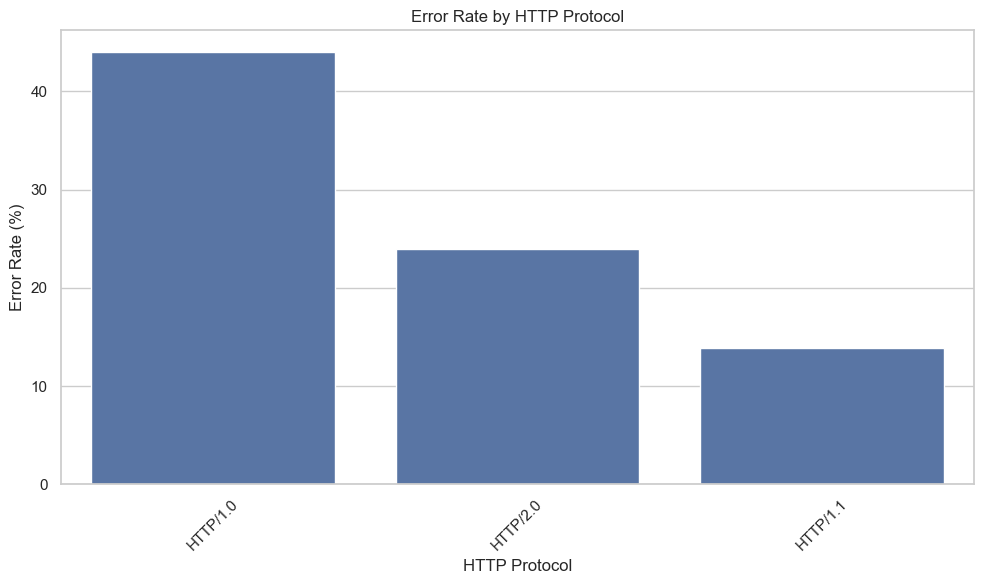

{'protocol_stats':        http   total  error_count  error_rate
0  HTTP/1.0     125           55   44.000000
2  HTTP/2.0   68093        16319   23.965753
1  HTTP/1.1  127617        17724   13.888432, 'contingency_full': is_error       0      1
http                   
HTTP/1.0      70     55
HTTP/1.1  109893  17724
HTTP/2.0   51774  16319, 'contingency_test': is_error       0      1
http                   
HTTP/1.0      70     55
HTTP/1.1  109893  17724
HTTP/2.0   51774  16319, 'test_result': {'test': 'chi2', 'chi2_statistic': np.float64(3197.162422024782), 'p_value': np.float64(0.0), 'degrees_of_freedom': 2, 'expected_counts': is_error              0             1
http                                 
HTTP/1.0     103.235504     21.764496
HTTP/1.1  105396.842898  22220.157102
HTTP/2.0   56236.921597  11856.078403}}


In [126]:
results = protocol_error_correlation(df_requests)
print(results)